In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
seed_value = 12321
# torch.manual_seed(seed_value)
np.random.seed(seed_value)
from numpy import array as arr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset, DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from torch import Tensor
from torch.nn import Transformer
import math

from typing import Tuple
import tensorflow as t

from statistics import mean

seed_value = 12321
torch.manual_seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# drive_path = 'drive/My Drive/Colab Notebooks/2456_wind_project/data/'

drive_path = 'drive/My Drive/2456_wind_proj/data/'

Mounted at /content/drive


# Data

In [4]:
df_plant_1_processed_final = pd.read_csv(drive_path + 'df_plant_1_processed_final.csv', index_col = 0)
df_plant_1_processed_sliding_window = pd.read_csv(drive_path + 'df_plant_1_processed_sliding_window.csv', index_col = 0)

In [5]:
df_plant_1_processed_final.shape

(52560, 10)

In [6]:
df_plant_1_processed_final.columns

Index(['hours', 'u', 'v', 'ws', 'wd_sin', 'wd_cos', 'month_sin', 'month_cos',
       'wp1', 'index_forecasted_weather'],
      dtype='object')

In [7]:
# # CHEATING BUT A SMALL ONE - DO THE MINMAX SCALER
# df_plant_1_processed_final["ws"] = df_plant_1_processed_final["ws"] / np.max(df_plant_1_processed_final["ws"])
# df_plant_1_processed_sliding_window["ws"] = df_plant_1_processed_sliding_window["ws"] / np.max(df_plant_1_processed_sliding_window["ws"])

In [8]:
df_plant_1_processed_final.index = pd.to_datetime(df_plant_1_processed_final.index)
df_plant_1_processed_sliding_window.index = pd.to_datetime(df_plant_1_processed_sliding_window.index)

In [9]:
mean_wp = np.mean(df_plant_1_processed_final["wp1"])
std_wp = np.std(df_plant_1_processed_final["wp1"])
print(mean_wp, std_wp)

0.2419958333333333 0.2387907644515535


In [10]:
df_plant_1_processed_final["ws"] = (df_plant_1_processed_final["ws"] - np.mean(df_plant_1_processed_final["ws"])) / np.std(df_plant_1_processed_final["ws"])
df_plant_1_processed_final["wd_sin"] = (df_plant_1_processed_final["wd_sin"] - np.mean(df_plant_1_processed_final["wd_sin"])) / np.std(df_plant_1_processed_final["wd_sin"])
df_plant_1_processed_final["wd_cos"] = (df_plant_1_processed_final["wd_cos"] - np.mean(df_plant_1_processed_final["wd_cos"])) / np.std(df_plant_1_processed_final["wd_cos"])
# df_plant_1_processed_final["wp1"] = (df_plant_1_processed_final["wp1"] - np.mean(df_plant_1_processed_final["wp1"])) / np.std(df_plant_1_processed_final["wp1"])
df_plant_1_processed_final["u"] = (df_plant_1_processed_final["u"] - np.mean(df_plant_1_processed_final["u"])) / np.std(df_plant_1_processed_final["u"])
df_plant_1_processed_final["v"] = (df_plant_1_processed_final["v"] - np.mean(df_plant_1_processed_final["v"])) / np.std(df_plant_1_processed_final["v"])

df_plant_1_processed_sliding_window["ws"] = (df_plant_1_processed_sliding_window["ws"] - np.mean(df_plant_1_processed_sliding_window["ws"])) / np.std(df_plant_1_processed_sliding_window["ws"])
df_plant_1_processed_sliding_window["wd_sin"] = (df_plant_1_processed_sliding_window["wd_sin"] - np.mean(df_plant_1_processed_sliding_window["wd_sin"])) / np.std(df_plant_1_processed_sliding_window["wd_sin"])
df_plant_1_processed_sliding_window["wd_cos"] = (df_plant_1_processed_sliding_window["wd_cos"] - np.mean(df_plant_1_processed_sliding_window["wd_cos"])) / np.std(df_plant_1_processed_sliding_window["wd_cos"])
# df_plant_1_processed_sliding_window["wp1"] = (df_plant_1_processed_sliding_window["wp1"] - np.mean(df_plant_1_processed_sliding_window["wp1"])) / np.std(df_plant_1_processed_sliding_window["wp1"])
df_plant_1_processed_sliding_window["u"] = (df_plant_1_processed_sliding_window["u"] - np.mean(df_plant_1_processed_sliding_window["u"])) / np.std(df_plant_1_processed_sliding_window["u"])
df_plant_1_processed_sliding_window["v"] = (df_plant_1_processed_sliding_window["v"] - np.mean(df_plant_1_processed_sliding_window["v"])) / np.std(df_plant_1_processed_sliding_window["v"])

In [11]:
df_plant_1_processed_final.drop(columns = ["hours", "index_forecasted_weather"]).head()

,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,wp1
2009-07-01 01:00:00,0.233662,-0.198982,-0.858144,0.928484,-0.382437,1.224647e-16,-1.0,0.085
2009-07-01 02:00:00,0.181121,-0.268072,-0.895117,0.873757,-0.518663,1.224647e-16,-1.0,0.020
2009-07-01 03:00:00,0.187689,-0.344071,-0.837016,0.821647,-0.621071,1.224647e-16,-1.0,0.060
2009-07-01 04:00:00,0.236946,-0.409707,-0.720814,0.793305,-0.669613,1.224647e-16,-1.0,0.045
2009-07-01 05:00:00,0.296054,-0.433888,-0.615176,0.803136,-0.653249,1.224647e-16,-1.0,0.035


# Data Preprocessing and Packing

In [12]:
df_sliding_window = df_plant_1_processed_sliding_window
df_weather_forecast = df_plant_1_processed_final

BATCHES_EXCLUDED = 5
WINDOW_SIZE = 12*BATCHES_EXCLUDED

INTERVAL = 48
TIMES_ONE_DATASET = 12
NUMBER_OF_48_PERIODS = int(df_weather_forecast.shape[0] / INTERVAL)
MORE_DATA_FOR_TRAINING = 12
PADDED_VALUE = -0.2

result = []
result_target = []

list_of_df_sliding_global = []
list_of_last_wp_global = []
list_of_current = []

window_size = WINDOW_SIZE
for i in range(NUMBER_OF_48_PERIODS - BATCHES_EXCLUDED):
    iterator = i + BATCHES_EXCLUDED
    df_temp = df_weather_forecast.iloc[INTERVAL*iterator: INTERVAL*(iterator+1), :]
    assert np.unique(df_temp.loc[:, "index_forecasted_weather"].values).shape[0] == 1
    array_values = df_temp.drop(columns = ["index_forecasted_weather", "hours"]).values

    end_sliding_window = df_temp.index[0] - pd.Timedelta(hours = 1)
    start_sliding_window = df_temp.index[0] - pd.Timedelta(hours = window_size)
    # MORE DATA FOR TRAINING
    end_sliding_window = end_sliding_window + pd.Timedelta(hours = MORE_DATA_FOR_TRAINING)
    df_window = df_sliding_window.loc[start_sliding_window:end_sliding_window, :]
    df_window = df_window.drop(columns = ["index_forecasted_weather", "hours"])

    target_list = array_values[:, array_values.shape[1] - 1][:, None]
    target_list_padded_values = np.full((array_values.shape[0] + 12, 1), fill_value = PADDED_VALUE)
    final_target_list = np.vstack((target_list, target_list_padded_values))

    explanatory_list = array_values[:, 0:(array_values.shape[1] - 1)]
    explanatory_list_padded_value = np.full((12, array_values.shape[1] - 1), fill_value = PADDED_VALUE)
    final_explanatory_list = np.vstack((explanatory_list, explanatory_list_padded_value))

    list_of_df_sliding = []
    list_of_last_wp = []
    explanatory_48_hours = []
    target_48_hours = []
    for j in range(MORE_DATA_FOR_TRAINING):
        df_sliding_tmp = df_window.iloc[j:j+window_size, :]
        list_of_df_sliding.append(df_sliding_tmp.values)
        # PROBLEM HERE WHEN SCALING - WP1 NEEDS TO BE CHANGE FOR WP
        list_of_last_wp.append(df_sliding_tmp.wp1[-10:].values)
        explanatory_48_hours.append(final_explanatory_list[j:j+INTERVAL, :])
        target_48_hours.append(final_target_list[j:j+INTERVAL, :])

    result.append(explanatory_48_hours)
    result_target.append(target_48_hours)

    list_of_df_sliding = arr(list_of_df_sliding)
    list_of_last_wp = arr(list_of_last_wp)

    list_of_df_sliding_global.append(list_of_df_sliding)
    list_of_last_wp_global.append(list_of_last_wp)

list_of_df_sliding_global = arr(list_of_df_sliding_global)
list_of_last_wp_global = arr(list_of_last_wp_global)[:, :, :, None]
result = arr(result)
result_target = arr(result_target)

print(list_of_df_sliding_global.shape, list_of_last_wp_global.shape, result.shape, result_target.shape)

(1090, 12, 60, 8) (1090, 12, 10, 1) (1090, 12, 48, 7) (1090, 12, 48, 1)


In [13]:
TEST_SET_PERCENT = 0.05
VALIDATION_SET_PERCENT = 0.05

TRUE_SIZE = NUMBER_OF_48_PERIODS - BATCHES_EXCLUDED
test_size = int(TRUE_SIZE * TEST_SET_PERCENT)
validation_size = int((TRUE_SIZE - test_size) * VALIDATION_SET_PERCENT)
train_size = TRUE_SIZE - validation_size - test_size
assert TRUE_SIZE == test_size + validation_size + train_size
train_size, validation_size, test_size

(985, 51, 54)

In [14]:
sliding_window = list_of_df_sliding_global
X_encoder_decoder = list_of_last_wp_global
X = result
y = result_target

In [15]:
# special == 3 implies that the max prediction horizon is 36 hours
SPECIAL = 3

sw_train = sliding_window[0:train_size - SPECIAL]
sw_train_special = sliding_window[train_size - SPECIAL:train_size]
sw_val = sliding_window[train_size: train_size + validation_size - SPECIAL, 0:1]
sw_val_special = sliding_window[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
sw_test = sliding_window[train_size + validation_size:, 0:1]

X_ed_train = X_encoder_decoder[0:train_size - SPECIAL]
X_ed_train_special = X_encoder_decoder[train_size - SPECIAL:train_size]
X_ed_val = X_encoder_decoder[train_size: train_size + validation_size - SPECIAL, 0:1]
X_ed_val_special = X_encoder_decoder[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
X_ed_test = X_encoder_decoder[train_size + validation_size:, 0:1]

X_train = X[0:train_size - SPECIAL]
X_train_special = X[train_size - SPECIAL:train_size]
X_val = X[train_size: train_size + validation_size - SPECIAL, 0:1]
X_val_special = X[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
X_test = X[train_size + validation_size:, 0:1]

y_train = y[0:train_size - SPECIAL]
y_train_special = y[train_size - SPECIAL:train_size]
y_val = y[train_size: train_size + validation_size - SPECIAL, 0:1]
y_val_sepcial = y[train_size + validation_size - SPECIAL: train_size + validation_size, 0:1]
y_test = y[train_size + validation_size:, 0:1]

print(sw_train.shape, sw_train_special.shape, sw_val.shape, sw_val_special.shape, sw_test.shape)
print()
print(X_ed_train.shape, X_ed_train_special.shape, X_ed_val.shape, X_ed_val_special.shape, X_ed_test.shape)
print()
print(X_train.shape, X_train_special.shape, X_val.shape, X_val_special.shape, X_test.shape)
print()
print(y_train.shape, y_train_special.shape, y_val.shape, y_val_sepcial.shape, y_test.shape)

(982, 12, 60, 8) (3, 12, 60, 8) (48, 1, 60, 8) (3, 1, 60, 8) (54, 1, 60, 8)

(982, 12, 10, 1) (3, 12, 10, 1) (48, 1, 10, 1) (3, 1, 10, 1) (54, 1, 10, 1)

(982, 12, 48, 7) (3, 12, 48, 7) (48, 1, 48, 7) (3, 1, 48, 7) (54, 1, 48, 7)

(982, 12, 48, 1) (3, 12, 48, 1) (48, 1, 48, 1) (3, 1, 48, 1) (54, 1, 48, 1)


Evaluation and testing is not conducted on the additional data with padding, only on the full weather prediction, those will be prediction conditions

# DataLoaders Pytroch

In [16]:
class Dataset_one_plant(torch.utils.data.Dataset):
    def __init__(self, sw, X_ed, X, y):
        self.sw = torch.from_numpy(sw.reshape((sw.shape[0]*sw.shape[1], sw.shape[2], sw.shape[3]))).float()
        self.X_ed = torch.from_numpy(X_ed.reshape((X_ed.shape[0]*X_ed.shape[1], X_ed.shape[2], X_ed.shape[3]))).float() 
        self.X = torch.from_numpy(X.reshape((X.shape[0]*X.shape[1], X.shape[2], X.shape[3]))).float()
        self.y = torch.from_numpy(y.reshape((y.shape[0]*y.shape[1], y.shape[2], y.shape[3]))).float()

    def __len__(self):
        return self.sw.shape[0]

    def __getitem__(self, index):
        result_dict = {}
        result_dict["sw"] = self.sw[index]
        result_dict["X_ed"] = self.X_ed[index]
        result_dict["X"] = self.X[index]
        result_dict["y"] = self.y[index]
        return result_dict

In [17]:
dataset_train = Dataset_one_plant(sw_train, X_ed_train, X_train, y_train)
dataset_train_special = Dataset_one_plant(sw_train_special, X_ed_train_special, X_train_special, y_train_special)
dataset_val = Dataset_one_plant(sw_val, X_ed_val, X_val, y_val)
dataset_val_special = Dataset_one_plant(sw_val_special, X_ed_val_special, X_val_special, y_val_sepcial)
dataset_test = Dataset_one_plant(sw_test, X_ed_test, X_test, y_test)

In [18]:
MULTIPLICATION = 1
BATCH_SIZE = int(12*MULTIPLICATION)
# BATCH_SIZE_TRAIN = 6
# BATCH_SIZE_EVAL = 1 # ALWAYS !!! bc we do prediction only at 0:00 and 12:00.
BATCH_SIZE_SPECIAL = 1

dataloader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = False)
dataloader_train_special = DataLoader(dataset_train_special, batch_size = BATCH_SIZE, shuffle = False)
dataloader_val = DataLoader(dataset_val, batch_size = BATCH_SIZE, shuffle = False)
dataloader_val_special = DataLoader(dataset_val_special, batch_size = BATCH_SIZE_SPECIAL, shuffle = False)
dataloader_test = DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = False)
print(len(dataloader_train), len(dataloader_train_special), len(dataloader_val),
      len(dataloader_val_special), len(dataloader_test))

982 3 4 3 5


# Transformer Model

In [19]:
def reset_weights(m):
  '''
 Reset model weights to avoid leakage of weights
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [20]:
# this class is needed for the positional encoding of the data. 
# We want to have a sense of when the data is recorded is important. Otherwise the order wouldn't be considered
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [21]:
class TimeSeriesTransformer(nn.Module):

    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding 
    layers and linear mapping layers are separate from the encoder and decoder, 
    i.e. the encoder and decoder only do what is depicted as their sub-layers 
    in the paper. For practical purposes, this assumption does not make a 
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the 
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017) 
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint]. 
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )
        
        self.sigmoid = nn.Sigmoid()
        
        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
        #    print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
        #    print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        decoder_output = self.sigmoid(decoder_output)
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

## Helper Functions Transformer Model

In [22]:
size_1 = (10, 48, 1)
size_2 = (10, 48, 1)
x_dummy_1 = np.random.normal(0, 1, size_1)
x_dummy_2 = np.random.normal(0, 1, size_2)
x_dummy = get_variable(Variable(torch.from_numpy(x_dummy_1).float()))
x_dummy.shape

torch.Size([10, 48, 1])

In [23]:
def get_src_trg(
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]

        trg = trg[:,:]
        #print("test - " + str(trg.shape))

        if len(trg.shape) == 1:

            trg = trg.unsqueeze(-1)

        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        # We only want trg_y to consist of the target variable not any potential exogenous variables
        trg_y = trg_y[:, :]

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

In [24]:
# this function is for generating the mask (Decoder input masking)
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

# Test Transformer Model

In [25]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 5 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.
enc_seq_len = 12 #153 # length of input given to encoder. Can have any integer value.
output_sequence_length = 36 #58 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

# added from model which was default 1
num_predicted_features = 1 #-> the number of the predicted features

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    batch_first=False,
    #max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    num_predicted_features=num_predicted_features,
    )
model.to(device)

TimeSeriesTransformer(
  (encoder_input_layer): Linear(in_features=5, out_features=512, bias=True)
  (decoder_input_layer): Linear(in_features=5, out_features=512, bias=True)
  (linear_mapping): Linear(in_features=512, out_features=1, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sigmoid): Sigmoid()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)

In [26]:
# TOY DATA
toy_size = 10
sw_toy = sw_train[0:toy_size]
X_ed_toy = X_ed_train[0:toy_size]
X_toy = X_train[0:toy_size]
y_toy = y_train[0:toy_size]
print(sw_toy.shape, X_ed_toy.shape, X_toy.shape, y_toy.shape)
print()

batch_size_toy = 12
dataset_toy = Dataset_one_plant(sw_toy, X_ed_toy, X_toy, y_toy)
dataloader_toy = DataLoader(dataset_toy, batch_size = batch_size_toy, shuffle = False)
print(len(dataloader_toy), batch_size_toy)

(10, 12, 60, 8) (10, 12, 10, 1) (10, 12, 48, 7) (10, 12, 48, 1)

10 12


In [27]:
# SANITY CHECK
dict_toy = next(iter(dataloader_toy))
sw_toy = dict_toy["sw"].to(device)
X_ed_toy = dict_toy["X_ed"].to(device)
X_toy = dict_toy["X"].to(device)
y_toy = dict_toy["y"].to(device)

In [28]:
X_toy.shape

torch.Size([12, 48, 7])

In [29]:
# create dummi data (sequence of random values) and create corresponding src, trg
data_len = (enc_seq_len+output_sequence_length)
print(data_len)

#dummi_data = torch.rand(64, 148, 3)
#dummi_data = X_toy.permute(1,0,2) # bring data in right permutation. Could possible use batch_first=True instead
dummi_data = get_variable(X_toy[:,:,:])

print(dummi_data.shape)

dummi_data = dummi_data.permute(1,0,2)
print(dummi_data.shape)


#dummi_ = [dummi_data[i] for i in range(len(dummi_data))]
#print(len(dummi_))
src, trg, _ = get_src_trg(sequence=dummi_data, 
                          enc_seq_len=enc_seq_len, 
                          target_seq_len=output_sequence_length)

# switch the first and second axis again for the batch to be first
#src = src.permute(1,0,2)
#trg = trg.permute(1,0,2)

#src = src[:,:] 

print("src - " + str(src.shape))
print("trg - " + str(trg.shape))

# create tgt_mask and src_mask
tgt_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=output_sequence_length
   )
src_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )

#print(tgt_mask.shape)
#print(src_mask.shape)
src.to(device)
trg.to(device)
src_mask.to(device)
tgt_mask.to(device)

model.float()
src.float()
trg.float()
src_mask.float()
tgt_mask.float()



# test model
#output = model(
#    src=src, 
#    tgt=trg,
#    src_mask=src_mask,
#    tgt_mask=tgt_mask,
#    )

#print(output.permute(1,0,2).shape)
#print(output.flatten())



48
torch.Size([12, 48, 7])
torch.Size([48, 12, 7])
src - torch.Size([12, 12, 7])
trg - torch.Size([36, 12, 7])


tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Hyperparameter Settings

In [30]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [31]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [32]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_val_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, start_epoch=0):
      # when continue epoch from loaded model
      self.epoch_count = start_epoch

      self.run_start_time = time.time()

      self.run_params = run
      self.run_count += 1

      self.network = network
      self.loader = loader
      self.tb = SummaryWriter(comment=f'-{run}')

      #images, labels = next(iter(self.loader))
      #grid = torchvision.utils.make_grid(images)

      #self.tb.add_image('images', grid)
      #self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
      self.tb.close()
      self.epoch_count = 0

    # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
      self.epoch_start_time = time.time()

      self.epoch_count += 1
      self.epoch_loss = 0
      self.epoch_val_loss = 0
      self.epoch_num_correct = 0

  # 
  def end_epoch(self):
      # calculate epoch duration and run duration(accumulate)
      epoch_duration = time.time() - self.epoch_start_time
      run_duration = time.time() - self.run_start_time

      # record epoch loss and accuracy
      loss = self.epoch_loss #/ len(self.loader.dataset)
      val_loss = self.epoch_val_loss #/ len(self.loader.dataset)

      # Record epoch loss and accuracy to TensorBoard 
      self.tb.add_scalar('Loss', loss, self.epoch_count)

      # Write into 'results' (OrderedDict) for all run related data
      results = OrderedDict()
      results["run"] = self.run_count
      results["epoch"] = self.epoch_count
      results["loss"] = loss
      results["val_loss"] = val_loss
      results["epoch duration"] = epoch_duration
      results["run duration"] = run_duration

      # Record hyper-params into 'results'
      for k,v in self.run_params._asdict().items(): results[k] = v
      self.run_data.append(results)
      df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

      # display epoch information and show progress
      clear_output(wait=True)
      display(df)

    # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
      # multiply batch size so variety of batch sizes can be compared
      self.epoch_loss += loss #* self.loader.batch_size

    # accumulate loss of batch into entire epoch loss
  def track_val_loss(self, loss):
      # multiply batch size so variety of batch sizes can be compared
      self.epoch_val_loss += loss #* self.loader.batch_size

    # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
      self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
      return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

      pd.DataFrame.from_dict(
          self.run_data, 
          orient = 'columns',
      ).to_csv(f'{fileName}.csv')

      with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
        json.dump(self.run_data, f, ensure_ascii=False, indent=4)

# Load Model

In [33]:
model_loaded = False
if model_loaded:
    model_name = "transformer_model2_1671182905.2592723.pt"
    model_path = str(drive_path[0:-5]) + "trained_model/" + str(model_name)
    checkpoint = torch.load(model_path)
#model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer'])


# Training

In [34]:
torch.cuda.is_available()

True

In [35]:
from collections import OrderedDict

# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [1e-05],
    dim_val = [48],
    n_heads = [4],
    n_decoder_layers = [4],
    n_encoder_layers = [4],
    #batch_size = [1, 2],
    weight_decay = [0.011],
)

In [36]:
#@title
m = RunManager()
num_epochs = 50

target_len = 36
n_steps_ahead_to_predict = target_len


## Model parameters
#dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
#n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
#n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.
enc_seq_len = 12 #153 # length of input given to encoder. Can have any integer value.
output_sequence_length = 36 #58 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

# added from model which was default 1
num_predicted_features = 1 #-> the number of the predicted features



# get all runs from params using RunBuilder class
for param in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    learning_rate = param.lr
    dim_val = param.dim_val
    n_decoder_layers = param.n_decoder_layers
    n_encoder_layers = param.n_encoder_layers
    WEIGHT_DECAY = param.weight_decay
    model = TimeSeriesTransformer(dim_val=dim_val,
                                    input_size=input_size, 
                                    dec_seq_len=dec_seq_len,
                                    batch_first=False,
                                    #max_seq_len=max_seq_len,
                                    out_seq_len=output_sequence_length, 
                                    n_decoder_layers=n_decoder_layers,
                                    n_encoder_layers=n_encoder_layers,
                                    n_heads=n_heads,
                                    num_predicted_features=num_predicted_features,
                                    )
    # if loaded model

    model.float()
    if torch.cuda.is_available():
      model.cuda()

    dataloader_train = DataLoader(dataset_train, batch_size = 12, shuffle = False)
    criterion = nn.MSELoss()
    optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)

    # if loaded model
    if model_loaded:
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])

        for g in optimizer.param_groups:
          g['lr'] = learning_rate

        epoch_loaded = checkpoint['epoch']
        loss = checkpoint['loss']
        # hyper training log
        m.begin_run(param, model, dataloader_train, start_epoch=epoch_loaded)
    else:
        # hyper training log
        m.begin_run(param, model, dataloader_train)


    train_loss_epochs = []
    loss_prediction_horizon_epochs = []
    train_output_epochs = []
    train_target_epochs = []

    val_loss_epochs = []
    loss_prediction_horizon_epochs_val = []
    val_output_epochs = []
    val_target_epochs = []

    for epoch in range(num_epochs):

        # hyper training log
        m.begin_epoch()

        train_loss = []
        # we keep it only for the last epoch of trining
        train_output = []
        train_target = []
        loss_prediction_horizon_list = []

        val_loss = []
        # we keep it only for the last epoch of trining
        val_output = []
        val_target = []
        loss_prediction_horizon_list_val = []

        ####################### MODEL TRAIN ###########################
        model.train()
        for batch_train_index, dictionary_values in enumerate(dataloader_train):

            sw = dictionary_values["sw"].to(device)
            X_ed = dictionary_values["X_ed"].to(device)
            X = dictionary_values["X"].to(device)
            y = dictionary_values["y"].to(device)

            # get input
            inputs = get_variable(X[:,:,:])
            #print(inputs.shape)

            inputs = inputs.permute(1,0,2)

            #print(inputs.shape)
            #print(enc_seq_len+output_sequence_length)

            # src, trg
            src, trg, _ = get_src_trg(sequence=inputs, 
                          enc_seq_len=enc_seq_len, 
                          target_seq_len=output_sequence_length)

            #src = src.permute(1,0,2)
            #trg = trg.permute(1,0,2)

            # create tgt_mask and src_mask
            tgt_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=output_sequence_length
              )
            src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
                )
            
            # to float
            src.float()
            trg.float()
            src_mask.float()
            tgt_mask.float()

            # to cuda
            if torch.cuda.is_available():
              src = src.cuda()
              trg = trg.cuda()
              src_mask = src_mask.cuda()
              tgt_mask = tgt_mask.cuda()   

            # forward pass
            train_outputs = model(
                src=src, 
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask,
                )
            train_outputs = train_outputs.permute(1,0,2)
            
            optimizer.zero_grad()

            # loss
            loss = criterion(get_variable(train_outputs.flatten()), 
                                    get_variable(y[:, 0:target_len, :].flatten()))    
            squared_error_2 = (get_variable(train_outputs) - get_variable(y[:, 0:target_len, :]))**2
            loss_prediction_horizon = torch.mean(squared_error_2, dim = 0).T

            # optimizer step
            loss.backward()
            optimizer.step()
            
            # keep track
            train_loss.append(get_numpy(torch.sqrt(loss)).item())
            loss_prediction_horizon_list.append(get_numpy(torch.squeeze(torch.sqrt(loss_prediction_horizon))))

            train_output.append(get_numpy(train_outputs))
            train_target.append(get_numpy(y[:, 0:target_len]))

            #m.track_num_correct(torch.zeros(1,1),torch.zeros(1,1))


        loss_prediction_horizon_list = arr(loss_prediction_horizon_list)
        train_output = arr(train_output)
        train_target = arr(train_target)

        train_output_epochs.append(train_output)
        train_target_epochs.append(train_target)
        train_loss_epochs.append(mean(train_loss))
        loss_prediction_horizon_epochs.append(np.mean(loss_prediction_horizon_list, axis = 0))
        train_loss.clear()


#        enc_seq_len = 1 #153 # length of input given to encoder. Can have any integer value.
#        output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
#        max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder
#        ##################### TRAIN SPECIAL CASES ############################
#        for batch_train_index, dictionary_values in enumerate(dataloader_train_special):
#
#            sw = dictionary_values["sw"].to(device)
#            X_ed = dictionary_values["X_ed"].to(device)
#            X = dictionary_values["X"].to(device)
#            y = dictionary_values["y"].to(device)
#
#            # get input
#            inputs = get_variable(X[:,:,:])
#            inputs = inputs.permute(1,0,2)
#
#
#            # src, trg
#            src, trg, _ = get_src_trg(sequence=inputs, 
#                          enc_seq_len=enc_seq_len, 
#                          target_seq_len=output_sequence_length)
#
#            #src = src.permute(1,0,2)
#            #trg = trg.permute(1,0,2)
#
#            # create tgt_mask and src_mask
#            tgt_mask = generate_square_subsequent_mask(
#                dim1=output_sequence_length,
#                dim2=output_sequence_length
#              )
#            src_mask = generate_square_subsequent_mask(
#                dim1=output_sequence_length,
#                dim2=enc_seq_len
#                )
#            
#            # to float
#            src.float()
#            trg.float()
#            src_mask.float()
#            tgt_mask.float()
#
#            # to cuda
#            if torch.cuda.is_available():
#              src = src.cuda()
#              trg = trg.cuda()
#              src_mask = src_mask.cuda()
#              tgt_mask = tgt_mask.cuda()   
#
#            # forward pass
#            train_outputs = model(
#                src=src, 
#                tgt=trg,
#                src_mask=src_mask,
#                tgt_mask=tgt_mask,
#                )
#            train_outputs = train_outputs.permute(1,0,2)
#            
#            optimizer.zero_grad()
#
#            # CRUCIAL ONLY CHANGE FOR THE SPECIAL CASE
#            length = len(dataloader_train_special) - batch_train_index
#            difference = target_len - length
#            if difference <= 0:
#                loss = criterion(get_variable(train_outputs.flatten()), 
#                                            get_variable(y[:, 0:target_len, :].flatten())) 
#            else:
#                # difference > 0
#                loss = criterion(get_variable(train_outputs[:, 0:target_len - difference, :].flatten()), 
#                                            get_variable(y[:, 0:target_len - difference, :].flatten())) 
#            # backpropagation
#            loss.backward()
#            optimizer.step()
#            #nn.utils.clip_grad_norm_(model.parameters(), CLIP)


        ##################### MODEL VALIDATION ############################
        model.eval()
        for batch_train_index, dictionary_values in enumerate(dataloader_val):

            sw = dictionary_values["sw"].to(device)
            X_ed = dictionary_values["X_ed"].to(device)
            X = dictionary_values["X"].to(device)
            y = dictionary_values["y"].to(device)

            if len(X) != 12:
              continue

            # get input
            inputs = get_variable(X[:,:,:])
            inputs = inputs.permute(1,0,2)

            # src, trg
            src, trg, _ = get_src_trg(sequence=inputs, 
                          enc_seq_len=enc_seq_len, 
                          target_seq_len=output_sequence_length)

            #src = src.permute(1,0,2)
            #trg = trg.permute(1,0,2)

            # create tgt_mask and src_mask
            tgt_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=output_sequence_length
              )
            src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
                )
            
            # to float
            src.float()
            trg.float()
            src_mask.float()
            tgt_mask.float()

            # to cuda
            if torch.cuda.is_available():
              src = src.cuda()
              trg = trg.cuda()
              src_mask = src_mask.cuda()
              tgt_mask = tgt_mask.cuda()   

            # forward pass
            outputs = model(
                src=src, 
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask,
                )
            outputs = outputs.permute(1,0,2)

            loss = criterion(get_variable(outputs.flatten()), 
                                        get_variable(y[:, 0:target_len, :].flatten()))    
            squared_error_2 = (get_variable(outputs) - get_variable(y[:, 0:target_len, :]))**2
            loss_prediction_horizon = torch.mean(squared_error_2, dim = 0).T

            val_loss.append(get_numpy(torch.sqrt(loss)).item())
            loss_prediction_horizon_list_val.append(get_numpy(torch.squeeze(torch.sqrt(loss_prediction_horizon))))

            val_output.append(get_numpy(outputs))
            val_target.append(get_numpy(y[:, 0:target_len]))
        
        loss_prediction_horizon_list_val = arr(loss_prediction_horizon_list_val)
        val_output = arr(val_output)
        val_target = arr(val_target)

        val_output_epochs.append(val_output)
        val_target_epochs.append(val_target)
        # if len(val_loss) != 0:
        
        val_loss_epochs.append(mean(val_loss))
        print(f"epoch: {epoch + 1}; loss traing: {train_loss_epochs[-1]}")
        print(f"epoch: {epoch + 1}; val traing: {val_loss_epochs[-1]}")
        print()
        val_loss.clear()

        # hyper training log
        m.track_loss(train_loss_epochs[-1])
        m.track_val_loss(val_loss_epochs[-1])

        # hyper training log
        m.end_epoch()
    # hyper training log
    m.end_run()
        
# save training stats
m.save("hyperTraining")

train_loss_epochs = arr(train_loss_epochs)
train_output_epochs = np.squeeze(arr(train_output_epochs))
train_target_epochs = np.squeeze(arr(train_target_epochs))
loss_prediction_horizon_epochs = arr(loss_prediction_horizon_epochs)

val_loss_epochs = arr(val_loss_epochs)
val_output_epochs = np.squeeze(arr(val_output_epochs))
val_target_epochs = np.squeeze(arr(val_target_epochs))
loss_prediction_horizon_epochs_val = arr(loss_prediction_horizon_epochs_val)

,run,epoch,loss,val_loss,epoch duration,run duration,lr,dim_val,n_heads,n_decoder_layers,n_encoder_layers,weight_decay
0,1,1,0.210225,0.252910,38.894154,38.895878,0.00001,48,4,4,4,0.011
1,1,2,0.178696,0.243062,35.902201,74.814381,0.00001,48,4,4,4,0.011
2,1,3,0.171960,0.238930,35.984198,110.819205,0.00001,48,4,4,4,0.011
3,1,4,0.169268,0.237537,35.959232,146.794419,0.00001,48,4,4,4,0.011
4,1,5,0.167514,0.234779,36.130023,182.941828,0.00001,48,4,4,4,0.011
5,1,6,0.166729,0.233801,36.304592,219.262372,0.00001,48,4,4,4,0.011
6,1,7,0.166483,0.232051,36.644472,255.923307,0.00001,48,4,4,4,0.011
7,1,8,0.166931,0.229769,37.117869,293.060244,0.00001,48,4,4,4,0.011
8,1,9,0.167140,0.227464,36.327861,329.404855,0.00001,48,4,4,4,0.011
9,1,10,0.167831,0.225939,36.801257,366.223924,0.00001,48,4,4,4,0.011


In [37]:
get_numpy(torch.sqrt(loss)).item()

0.23850247263908386

## Testing

In [38]:
##################### MODEL TESTING ############################
test_loss = []
test_output = []
test_target = []
for batch_train_index, dictionary_values in enumerate(dataloader_test):

    sw = get_variable(dictionary_values["sw"])
    X_ed = get_variable(dictionary_values["X_ed"])
    X = get_variable(dictionary_values["X"])
    y = get_variable(dictionary_values["y"])

    #encoder_hidden = model.encoder.init_hidden(sw.shape[0])
    #outputs = torch.zeros(sw.shape[0], target_len, 1)

    #optimizer.zero_grad()
    #encoder_hidden = repackage_hidden(encoder_hidden)
    #encoder_output, encoder_hidden = model.encoder(sw, encoder_hidden)

    #hidden_backward = model.backward.init_hidden(sw.shape[0])
    #backward_output, _ = model.backward(X[:, 0:target_len + ADDITIONAL_STEPS_FUTURE, :], hidden_backward)

    #decoder_input_point = X_ed[:, -1:, :]
    #decoder_hidden = encoder_hidden
    #past_observations = X_ed[:, -PAST_OBSERVATIONS_FFNN_SIZE:, :]

    ## predict recursively ONLY
    #for t in range(target_len):
    #    decoder_input = torch.cat((X[:, t:t+1, :],
    #                                decoder_input_point), 2)
    #    hidden_state_backward = backward_output[:, t:t+1, :]
    #    decoder_output_point, decoder_hidden = \
    #    model.decoder(decoder_input, hidden_state_backward,
    #                    past_observations, X[:, t:t+1, :], decoder_hidden)
    #    outputs[:, t:t+1, :] = decoder_output_point
    #    decoder_input_point = decoder_output_point
    #    past_observations = torch.cat((past_observations[:, -PAST_OBSERVATIONS_FFNN_SIZE + 1:, :], decoder_input_point), dim = 1)#

    if len(X) != 12:
      continue

    # get input
    inputs = get_variable(X[:,:,:])
    inputs = inputs.permute(1,0,2)

    # src, trg
    src, trg, _ = get_src_trg(sequence=inputs, 
                              enc_seq_len=enc_seq_len, 
                              target_seq_len=output_sequence_length)

    # create tgt_mask and src_mask
    tgt_mask = generate_square_subsequent_mask(
        dim1=output_sequence_length,
        dim2=output_sequence_length
        )
    src_mask = generate_square_subsequent_mask(
        dim1=output_sequence_length,
        dim2=enc_seq_len
        )
            
    # to float
    src.float()
    trg.float()
    src_mask.float()
    tgt_mask.float()

    # to cuda
    if torch.cuda.is_available():
      src = src.cuda()
      trg = trg.cuda()
      src_mask = src_mask.cuda()
      tgt_mask = tgt_mask.cuda()   

    # forward pass
    outputs = model(
        src=src, 
        tgt=trg,
        src_mask=src_mask,
        tgt_mask=tgt_mask,
        )
    outputs = outputs.permute(1,0,2)

    loss = criterion(get_variable(outputs.flatten()), 
                                get_variable(y[:, 0:target_len, :].flatten()))    

    loss.backward()
    optimizer.step()
    #nn.utils.clip_grad_norm_(model.parameters(), CLIP)

    test_loss.append(get_numpy(torch.sqrt(loss)).item())

    test_output.append(get_numpy(outputs))
    test_target.append(get_numpy(y[:, 0:target_len]))

test_output = arr(test_output[:-1])
test_target = arr(test_target[:-1])

print(f"test_loss: {np.mean(test_loss)}")

test_loss: 0.18661893159151077


# Save Model

In [39]:
# save model to drive
import time

model_save_name = 'transformer_updated_model_' + str(time.time()) + '.pt'
#print(drive_path[0:-5])
path = str(drive_path[0:-5]) + "trained_model/" + str(model_save_name)

# count epochs different when loaded model was used
if model_loaded:
  epoch_count = len(train_loss_epochs) + m.run_data[-1]['epoch']
else:
  epoch_count = len(train_loss_epochs)
print(epoch_count)

torch.save({'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'loss': train_loss_epochs[-1],
              'epoch': epoch_count,
              }, path)

50


# Plotting the results

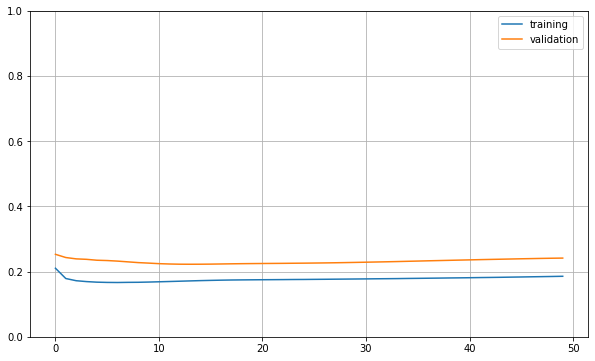

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

 

ax.plot(train_loss_epochs, label = "training")
ax.plot(val_loss_epochs, label = "validation")
ax.legend()
ax.grid(True)
ax.set_ylim(0, 1)

 

fig.savefig( str(drive_path[0:-5]) + "trained_model/plots/" + str(model_save_name) + '_model_loss_transf' + '.png')

In [41]:
def plotting_train_set():
    for i in range(10):
        epoch_last = -1
        number = 700 + 10*i
        addition = 3
        predictions_1 = train_output_epochs[epoch_last, number, 0].flatten()
        targets_1 = train_target_epochs[epoch_last, number, 0].flatten()
        predictions_2 = train_output_epochs[epoch_last, number + addition, 0].flatten()
        targets_2 = train_target_epochs[epoch_last, number + addition, 0].flatten()
        predictions_3 = train_output_epochs[epoch_last, number + 2*addition, 0].flatten()
        targets_3 = train_target_epochs[epoch_last, number + 2*addition, 0].flatten()

        fig, ax = plt.subplots(1, 3, figsize = (20, 4))
        y_min, y_max = 0, 1

        ax[0].plot(predictions_1, label = "predictions")
        ax[0].plot(targets_1, label = "targets")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].set_ylim([y_min, y_max])

        ax[1].plot(predictions_2, label = "predictions")
        ax[1].plot(targets_2, label = "targets")
        ax[1].legend()
        ax[1].grid(True)
        ax[1].set_ylim([y_min, y_max])

        ax[2].plot(predictions_3, label = "predictions")
        ax[2].plot(targets_3, label = "targets")
        ax[2].legend()
        ax[2].grid(True)
        ax[2].set_ylim([y_min, y_max])

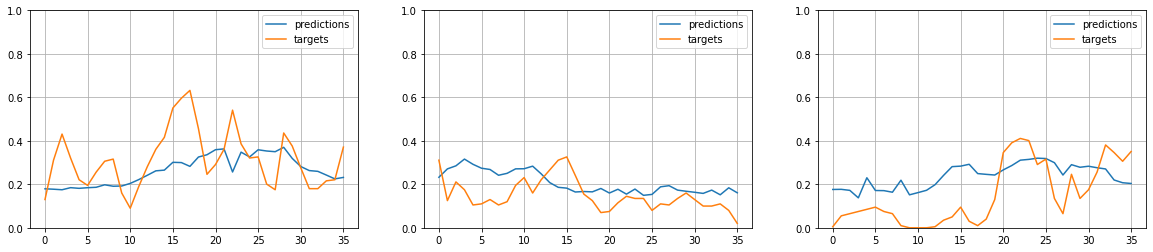

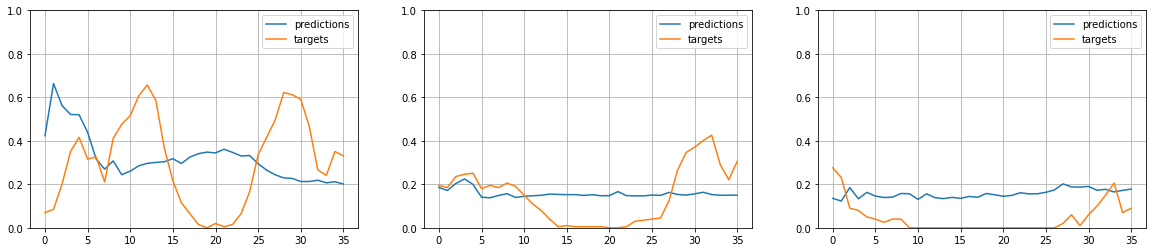

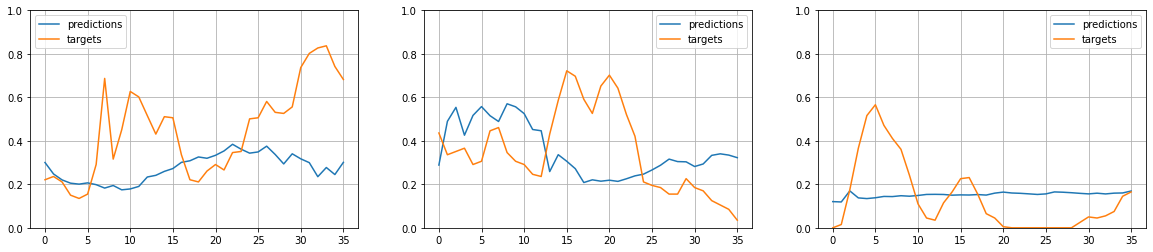

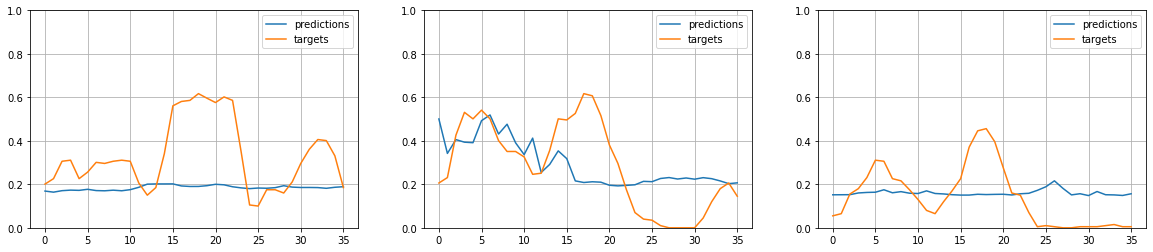

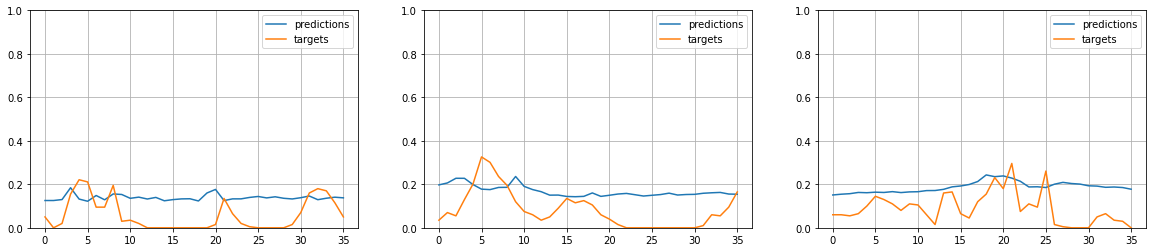

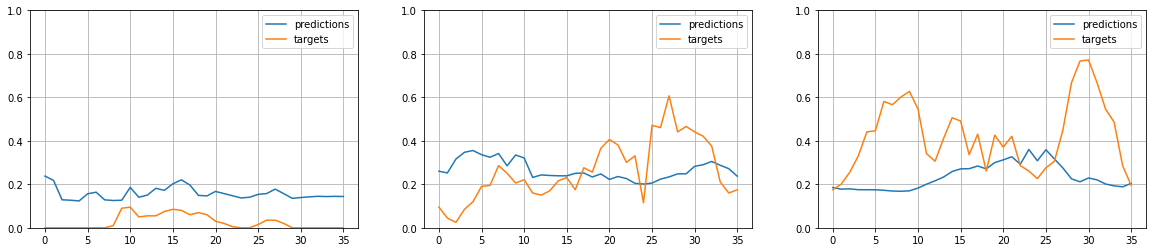

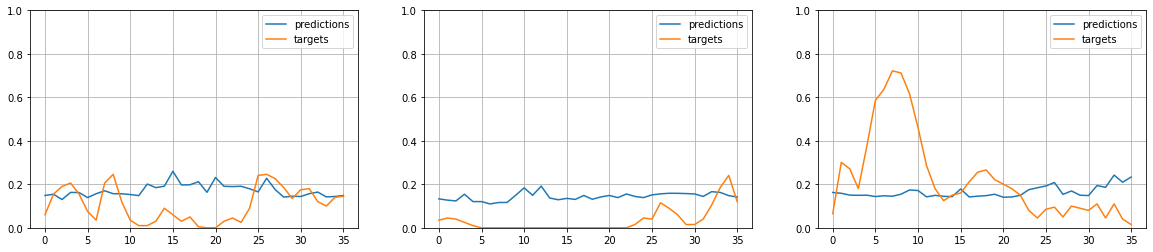

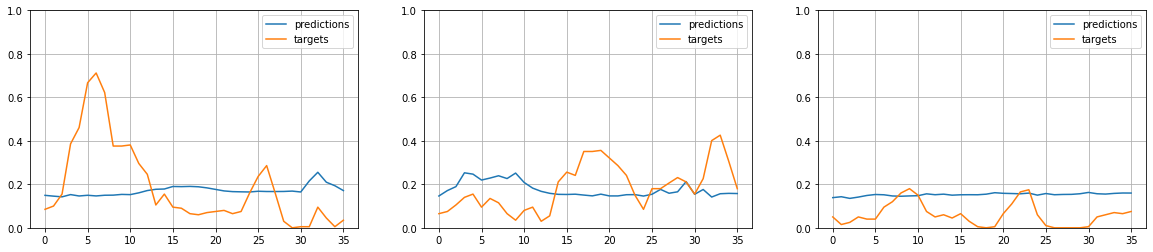

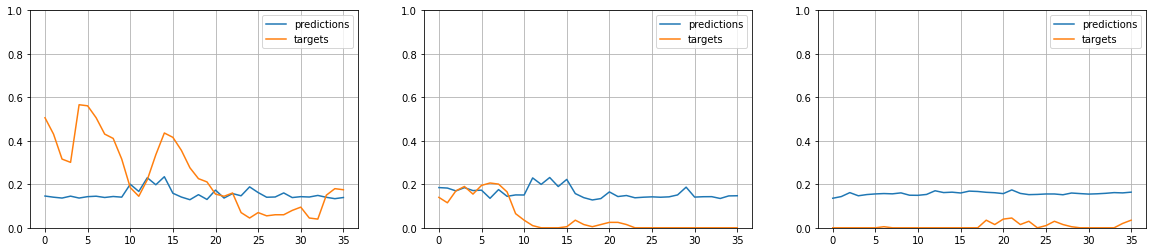

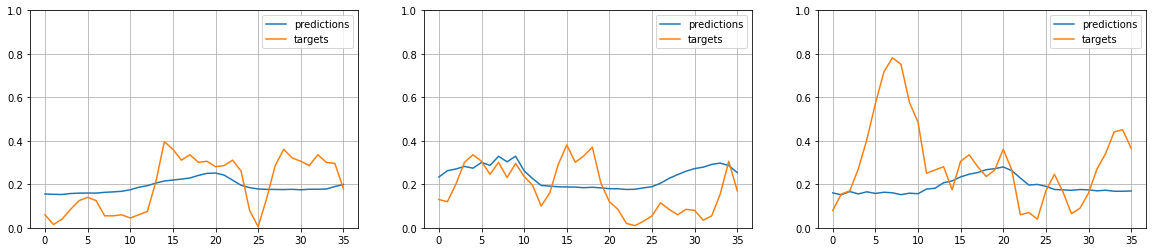

In [42]:
plotting_train_set()